In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from numpy.linalg import svd
import networkx as nx

import importlib

import dgsp
import graph_examples as dgsp_graphs
import plotting as dgsp_plot

In [29]:
path_to_nodes = "/Users/acionca/code/dGSP/dSVD/data/email-Enron/email-Enron-node-labels.txt.gz"
path_to_simplices = "/Users/acionca/code/dGSP/dSVD/data/email-Enron/email-Enron-simplices.txt.gz"
path_to_nverts = "/Users/acionca/code/dGSP/dSVD/data/email-Enron/email-Enron-nverts.txt.gz"

node = pd.read_csv(path_to_nodes, sep=" ", header=None)
simplices = pd.read_csv(path_to_simplices, sep=" ", header=None)
nverts = pd.read_csv(path_to_nverts, sep=" ", header=None)

print(len(node))
print(len(node) * (len(node) - 1) // 2)
print(len(simplices))
print(len(nverts))

148
10878
26841
10883


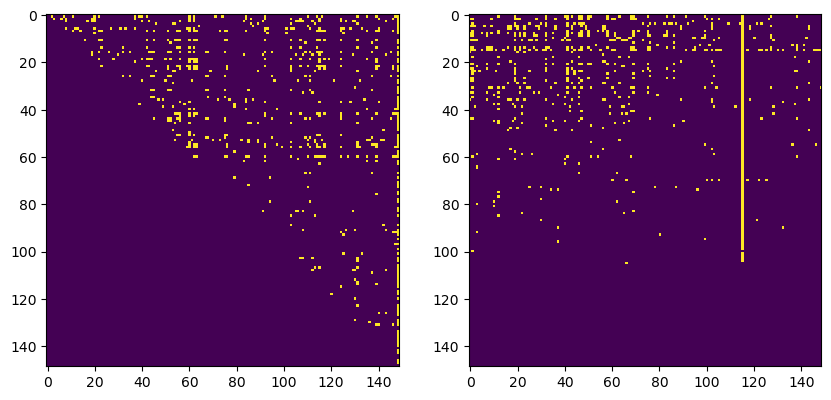

In [61]:
path_to_edges = "/Users/acionca/code/dGSP/dSVD/data/phs-email-Enron/email-Enron.txt"
path_to_cores = "/Users/acionca/code/dGSP/dSVD/data/phs-email-Enron/core-email-Enron.txt"

cores = np.genfromtxt(path_to_cores, delimiter=" ", dtype=int)
n_nodes = cores.max() + 1

adjacency_matrix = np.zeros((n_nodes, n_nodes))
with open(path_to_edges, "r") as f:
    edges = f.readlines()

    for line in edges:
        parsed_lines = line.split("\n")[0].split(" ")
        sender = int(parsed_lines[0])
        receivers = np.clip([int(x) - 1 for x in parsed_lines[1:]], a_min=0, a_max=n_nodes-1)

        adjacency_matrix[sender - 1, receivers] += 1
        #for r in receivers:
        #    adjacency_matrix[sender - 1, np.clip(r - 1, a_min=0, a_max=n_nodes-1)] += 1

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].imshow(adjacency_matrix, vmax=1, interpolation="none")

sort_by_deg = np.flip(np.argsort(np.sum(adjacency_matrix, axis=1)))
axes[1].imshow(adjacency_matrix[sort_by_deg][:, sort_by_deg], vmax=1, interpolation="none")

[-0.02019807  0.06308894]


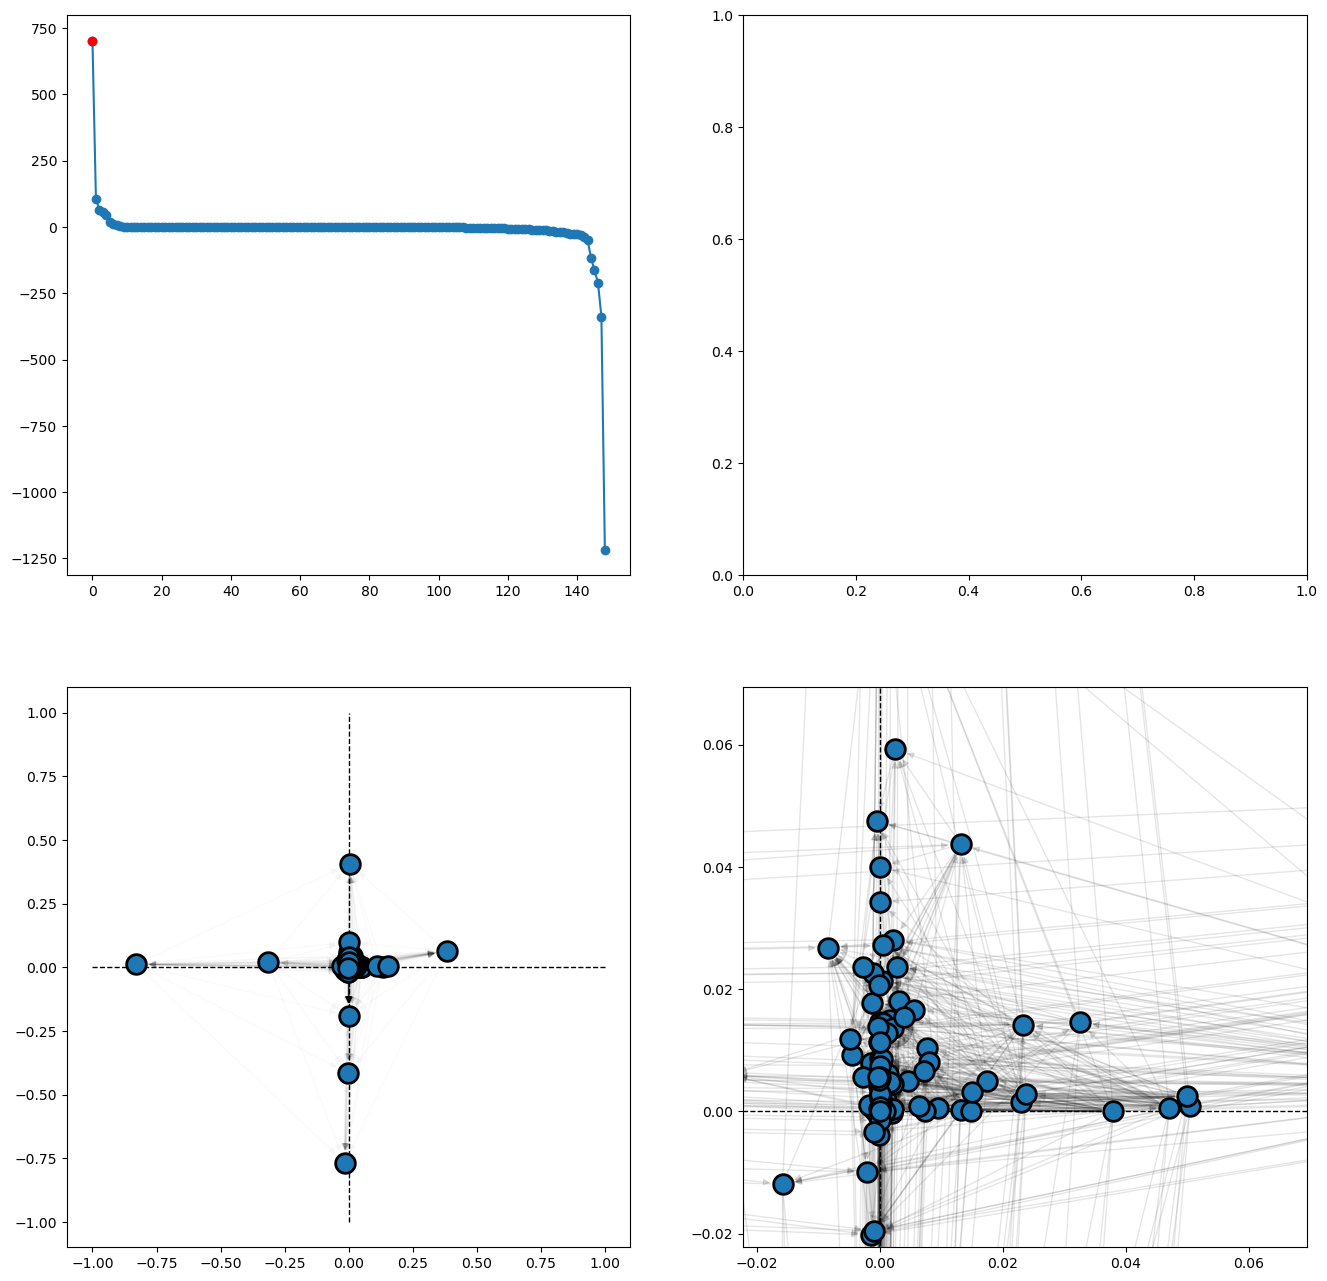

In [94]:
matrix = adjacency_matrix

# Building the modularity matrix
modmat = dgsp.modularity_matrix(matrix, null_model="outin")
U, S, Vh = dgsp.sorted_SVD(modmat)
V = Vh.T

vector_id = 0
n_nodes = matrix.shape[0]
perc_zoom = 2

graph_pos = {i: (U[i, vector_id], V[i, vector_id]) for i in range(n_nodes)}
labels = {i: "" for i in range(n_nodes)}

_, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

axes[0, 0].plot(S, "o-")
axes[0, 0].plot(vector_id, S[vector_id], "ro-")

for ax_i, ax in enumerate(axes[1]):
    alpha = 0.02
    if ax_i > 0:
        perc_range = np.percentile(np.hstack([U[:, vector_id], V[:, vector_id]]), [perc_zoom, 100-perc_zoom], interpolation="nearest")
        print(perc_range)
        ax.set_xlim(1.1*perc_range)
        ax.set_ylim(1.1*perc_range)
        # ax.set_xlim(-.05, .075)
        # ax.set_ylim(-.05, .075)
        alpha = 0.1

    nx.draw_networkx_edges(nx.DiGraph(matrix), pos=graph_pos, alpha=alpha, ax=ax)

    colors = "tab:blue"

    ax.scatter(
        U[:, vector_id],
        V[:, vector_id],
        s=200,
        color=colors,
        edgecolor="k",
        linewidth=2,
        zorder=2,
    )

    ax.plot([0, 0], [-1, 1], "k--", lw=1, zorder=0)
    ax.plot([-1, 1], [0, 0], "k--", lw=1, zorder=0)

    # Parameters
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)